<a href="https://colab.research.google.com/github/jiansim03/AIFFEL_ONLINE_QUEST/blob/main/Quest09/human_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6-1. 프로젝트: 인물 모드 문제점 찾기
---

In [ ]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [ ]:
from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


## Step 1. 인물모드 직접 해 보기
---
- 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다.

### 1 : 고양이 + 흐린배경

In [ ]:
img_path_1 = os.getenv('HOME') + '/aiffel/human_segmentation/images/cat.png'
img_orig_1 = cv2.imread(img_path_1)
print(img_orig_1.shape)
# img_orig_1

(149, 200, 3)


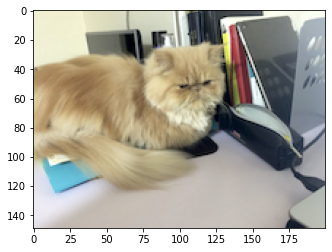

In [ ]:
# 이미지 출력해보기
plt.imshow(cv2.cvtColor(img_orig_1, cv2.COLOR_BGR2RGB)) # 이미지 채널 변경하여 데이터를 이미지 형식으로 표시
plt.show()

In [ ]:
# 모델 생성
# 모델 이미 다운 받아져 있으므로 경로만 지정
model_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
print(model_file)

/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5


In [ ]:
model = semantic_segmentation() # PixelLib 라이브러리로부터 해당 모듈 임포트
model.load_pascalvoc_model(model_file) # pascal voc에 대해 xecption 모델 로드

In [ ]:
# 모델에 1번 이미지 입력
# output : 분할된 이미지
segvalues_1, output_1 = model.segmentAsPascalvoc(img_path_1) # segmentAsPascalvoc() 함수 호출

In [ ]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [ ]:
segvalues_1

{'class_ids': array([ 0,  8,  9, 20]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [ ]:
# 객체로 인식한 목록 출력
for i in segvalues_1['class_ids']:
    print(LABEL_NAMES[i])

background
cat
chair
tv


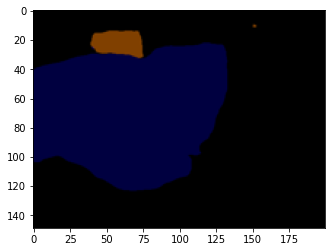

In [ ]:
# segmentAsPascalvoc함수로 이미지 분할된 결과 출력
# 객체 별로 다른 색상으로 표시된다
plt.imshow(output_1)
plt.show()

In [ ]:
# output에는 segmentation 결과가 각각 다른 색상으로 담겨있음. 어떤 색상으로 나타나 있는지 알아보자

# 컬러맵 만들기
# PixelLib에서 각 객체를 분류하는 색상을 배열로 출력해주는 함수이다
# 예를 들어 0번인 배경은 segmentation 후 검은색으로 표시되는데, 아래 배열에서 0번째 원소에 담겨있다.

colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [ ]:
colormap[8] #컬러맵 '8'에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 8번째인 고양이)

array([64,  0,  0])

In [ ]:
seg_color_1= [0, 0, 64] # 고양이 영역에 해당하는 컬러맵 색상

#### output에서 고양이 부분만 마스크 추출해내기

(149, 200)


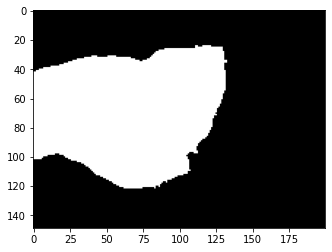

In [ ]:
seg_map_1 = np.all(output_1==seg_color_1, axis=-1) # output_1에서 seg_color_8에 해당하는 색상만 true로 표시
print(seg_map_1.shape)

plt.imshow(seg_map_1, cmap='gray') # true이외의 영역은 gray로 표시된다
plt.show()

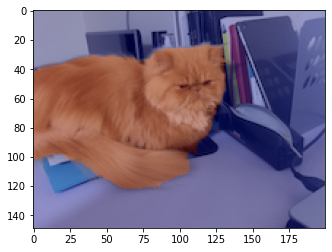

In [ ]:
img_show_1 = img_orig_1.copy()

img_mask_1 = seg_map_1.astype(np.uint8) * 255 # T/F를 255/0 으로 변환
color_mask_1 = cv2.applyColorMap(img_mask_1, cv2.COLORMAP_JET) # 0~255, 파~빨

# 원본이미지와 마스크를 겹쳐보자. 겹친 영역은 붉은 색으로 표시된다
img_show_1 =cv2.addWeighted(img_show_1, 0.6, color_mask_1, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_1, cv2.COLOR_BGR2RGB))
plt.show()

#### 배경 흐리게 하기

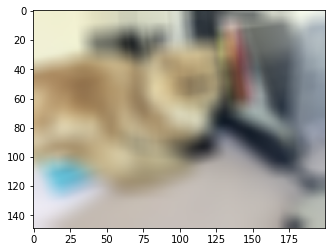

In [ ]:
img_orig_blur_1 = cv2.blur(img_orig_1, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur_1, cv2.COLOR_BGR2RGB)) # cv2라이브러리로 BGR > RGB 변환
plt.show()

In [ ]:
img_mask_1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

#### 마스크 씌워 배경만 얻어내기

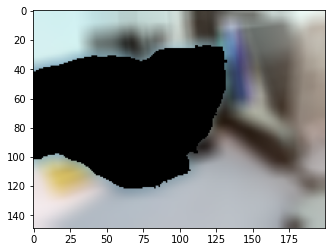

In [ ]:
img_mask_color_1 = cv2.cvtColor(img_mask_1, cv2.COLOR_GRAY2BGR) # grayscale > BGR
img_bg_mask_1 = cv2.bitwise_not(img_mask_color_1) # 배경: 0, 고양이: 255 > 배경: 255, 고양이 0 (배경만 걸러내는 마스크)

img_bg_blur_1 = cv2.bitwise_and(img_orig_blur_1 ,img_bg_mask_1) # 블러된 이미지와 배경마스크가 겹치는 곳만 필터링된다
plt.imshow(img_bg_blur_1)
plt.show()

#### 흐린 배경과 원본 영상 합성

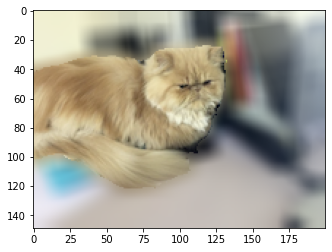

In [ ]:
img_concat_1 = np.where(img_mask_color_1 == 255, img_orig_1, img_bg_blur_1)

plt.imshow(cv2.cvtColor(img_concat_1, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 폴더에 작업된 이미지 다운 받기
cv2.imwrite('find_2.jpg', img_concat_1)

True

### 2 : 셀카 + 배경 블러
---

(533, 300, 3)


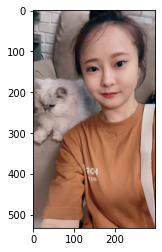

In [ ]:
img_path_2 = os.getenv('HOME') + '/aiffel/human_segmentation/images/selfie.jpeg' # 이미지 경로 지정한 후
img_orig_2 = cv2.imread(img_path_2) # cv2 라이브러리로 이미지 읽어들인다
print(img_orig_2.shape)

plt.imshow(cv2.cvtColor(img_orig_2, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 모델 로드
model = semantic_segmentation()
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 xeception 모델 로드

In [ ]:
# 모델에 이미지 입력
segvalue_2, output_2 = model.segmentAsPascalvoc(img_path_2)

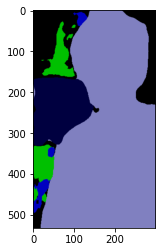

In [ ]:
# 분할된 결과물인 output을 이미지로 출력해본다
plt.imshow(output_2)
plt.show()

In [ ]:
# 분할된 각각의 객체가 무엇인지 label을 출력해본다
for i  in segvalue_2['class_ids']:
    print(i, LABEL_NAMES[i])

0 background
8 cat
9 chair
15 person
18 sofa


In [ ]:
# 사람 부분 마스크를 추출하기 위해 위 output_2에서 사람에 해당하는 색상만 뽑아내야한다
# colormap 변수에서 사람에 해당하는 색상은 15번째에 담겨있다

colormap[15]
seg_color_2 = (128, 128, 192)# colormap은 RGB순이고, output_2는 BGR순이므로 순서를 맞춰준다

(533, 300)


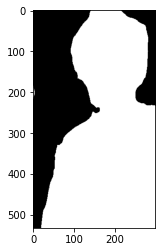

In [ ]:
seg_map_2 = np.all(output_2 == seg_color_2, axis=-1) # 텐서에서 채널축에 대하여 '사람' 색상에 해당되는 부분만 True가 된다
print(seg_map_2.shape)

plt.imshow(seg_map_2, cmap='gray') # grayscale로 매핑
plt.show()

#### 원래 이미지와 겹쳐보기

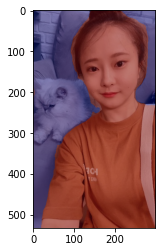

In [ ]:
img_show_2 = img_orig_2.copy() # 원본 복사
img_mask_2 = seg_map_2.astype(np.uint8)  * 255 # T/F 에서 255/0으로 변환해주기
color_mask_2 = cv2.applyColorMap(img_mask_2, cv2.COLORMAP_JET) # 마스크를 적당한 색상으로 변경해주기

img_show_2 = cv2.addWeighted(img_show_2, 0.6, color_mask_2, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_2, cv2.COLOR_BGR2RGB))
plt.show()

#### 배경 흐리게 하기

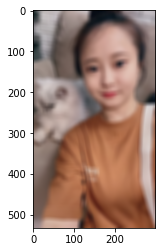

In [ ]:
img_orig_blur_2 = cv2.blur(img_orig_2, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur_2, cv2.COLOR_BGR2RGB))
plt.show()

#### 흐린 배경만 남게 하기

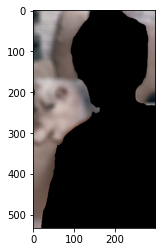

In [ ]:
img_mask_color_2 = cv2.cvtColor(img_mask_2, cv2.COLOR_GRAY2BGR) # 원본 형식힌 BGR순서로 변환

img_bg_mask_2 = cv2.bitwise_not(img_mask_color_2) # 배경/인물 부분 색상 반전시키기

img_bg_blur_2 = cv2.bitwise_and(img_orig_blur_2, img_bg_mask_2) # 배경 마스크와 블러 이미지 겹치는 부분만 제외하고 0이됨


plt.imshow(cv2.cvtColor(img_bg_blur_2, cv2.COLOR_BGR2RGB))
plt.show()

#### 흐린 배경과 원본의 인물 합성하기

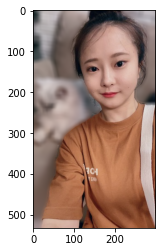

In [ ]:
img_concat_2 = np.where(img_mask_color_2 == 255, img_orig_2, img_bg_blur_2) # 마스크가 255인 경우에만 원본 표기, 아니면 블러

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 3 : 배경 크로마키

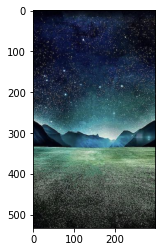

In [ ]:
# 배경 이미지 불러오기
img_path_3 = os.getenv('HOME') + '/aiffel/human_segmentation/images/selfie_bg.jpg'
img_orig_3 = cv2.imread(img_path_3)

plt.imshow(cv2.cvtColor(img_orig_3, cv2.COLOR_BGR2RGB))
plt.show()

#### 위의 배경과 원본의 인물 합성하기

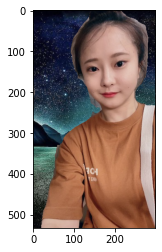

In [ ]:
img_concat_2 = np.where(img_mask_color_2 == 255, img_orig_2, img_orig_3) # 마스크가 255인 경우에만 원본 표기, 아니면 블러

plt.imshow(cv2.cvtColor(img_concat_2, cv2.COLOR_BGR2RGB))
plt.show()

## Step 2. 사진에서 문제점 찾기
---



#### (1) 첫번째 사진에서 이상한 부분 찾기

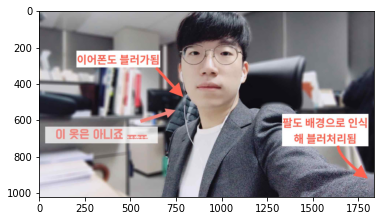

In [ ]:
img_path_4 = os.getenv('HOME') + '/aiffel/human_segmentation/images/find_1.jpg'
img_find_1 = cv2.imread(img_path_4)


plt.imshow(cv2.cvtColor(img_find_1, cv2.COLOR_BGR2RGB))
plt.show()

#### (1) 두번째 사진에서 이상한 부분 찾기

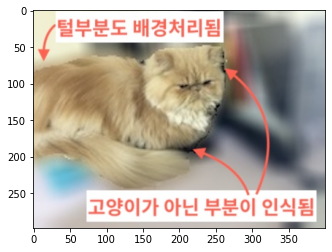

In [ ]:
img_path_5 = os.getenv('HOME') + '/aiffel/human_segmentation/images/find_2.jpg'
img_find_2 = cv2.imread(img_path_5)

plt.imshow(cv2.cvtColor(img_find_2, cv2.COLOR_BGR2RGB))
plt.show()

## Step 3. 해결 방법을 제안해 보기
---

#### 인식을 잘 못한 부분의 특징

- 대상 객체의 경계면 & 얇다(해당 영역에서 연속적으로 차지하는 픽셀의 수가 적음)   
_예) 고양이의 털, 이어폰_
- 경계면의 색상이 인접한 다른 객체와 유사하다  
_예) 인물 옆의 옷 등_


#### 해결방안
- 대상이 되는 객체의 경계면에서, 다른 클래스로의 픽셀과 섞여있는 비율이 높은 경우에, 대상 객체로 분류될 확률을 증가시킨다
- 대상객체의 경계면에서는 민감하게 색상을 구별하도록 한다. 대상 객체의 픽셀과 그렇지 않은 픽셀간의 수치 차이를 많이 두도록 한다.
